<a href="https://colab.research.google.com/github/MSVGH1/IAD/blob/main/%D0%9B%D0%A03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Відключимо різні попередження Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

In [3]:
# Створення датафрейму з dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Деякі значення ознак є в тестовій підвибірці, але немає в навчальній і навпаки
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [4]:
features = ['Зовнішність', 'Алкоголь_в_напої',
            'Рівень_харизми', 'Витрачені_гроші']

In [5]:
df_train = {}
df_train['Зовнішність'] = ['приємна', 'приємна', 'приємна', 'відштовхуюча',
                         'відштовхуюча', 'відштовхуюча', 'приємна'] 
df_train['Алкоголь_в_напої'] = ['так', 'так', 'ні', 'ні', 'так', 'так', 'так']
df_train['Рівень_харизми'] = ['високий', 'низький', 'середній', 'середній', 'низький',
                                   'високий', 'середній']
df_train['Витрачені_гроші'] = ['багато', 'мало', 'багато', 'мало', 'багато',
                                  'багато', 'багато']
df_train['Поїде'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поїде,Зовнішність_відштовхуюча,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так,Рівень_харизми_високий,Рівень_харизми_низький,Рівень_харизми_середній,Витрачені_гроші_багато,Витрачені_гроші_мало
0,0,0,1,0,1,1,0,0,1,0
1,1,0,1,0,1,0,1,0,0,1
2,0,0,1,1,0,0,0,1,1,0
3,1,1,0,1,0,0,0,1,0,1
4,1,1,0,0,1,0,1,0,1,0
5,0,1,0,0,1,1,0,0,1,0
6,0,0,1,0,1,0,0,1,1,0


In [6]:
df_test = {}
df_test['Зовнішність'] = ['приємна', 'приємна', 'відштовхуюча'] 
df_test['Алкоголь_в_напої'] = ['ні', 'так', 'так']
df_test['Рівень_харизми'] = ['середній', 'високий', 'середній']
df_test['Витрачені_гроші'] = ['багато', 'мало', 'багато']
df_test = create_df(df_test, features)
df_test

,Зовнішність_відштовхуюча,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так,Рівень_харизми_високий,Рівень_харизми_середній,Витрачені_гроші_багато,Витрачені_гроші_мало
0,0,1,1,0,0,1,1,0
1,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,1,0


In [7]:
# Деякі значення ознак є в тестовій підвибірці, але немає в навчальній і навпаки
y = df_train['Поїде']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Витрачені_гроші_багато,Рівень_харизми_високий,Зовнішність_відштовхуюча,Рівень_харизми_середній,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так,Витрачені_гроші_мало
0,1,1,0,0,1,0,1,0
1,0,0,0,0,1,0,1,1
2,1,0,0,1,1,1,0,0
3,0,0,1,1,0,1,0,1
4,1,0,1,0,0,0,1,0
5,1,1,1,0,0,0,1,0
6,1,0,0,1,1,0,1,0


In [8]:
df_test

,Витрачені_гроші_багато,Рівень_харизми_високий,Зовнішність_відштовхуюча,Рівень_харизми_середній,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так,Витрачені_гроші_мало
0,1,0,0,1,1,1,0,0
1,0,1,0,0,1,0,1,1
2,1,0,1,1,0,0,1,0


In [21]:
#Завдання 1
from math import log

s2 = -(2/3)*log(2/3, 2)-(1/3)*log(1/3, 2)

print(s2)


0.9182958340544896


In [20]:
#Побудуйте за допомогою sklearn дерево рішень, навчивши його на навчальній вибірці. Глибину можна не обмежувати.
first_tree =  DecisionTreeClassifier(criterion='entropy', random_state=17)
first_tree.fit(df_train, y)
export_graphviz(first_tree, out_file = 'new_tree.dot', feature_names =df_train.columns,filled=True)

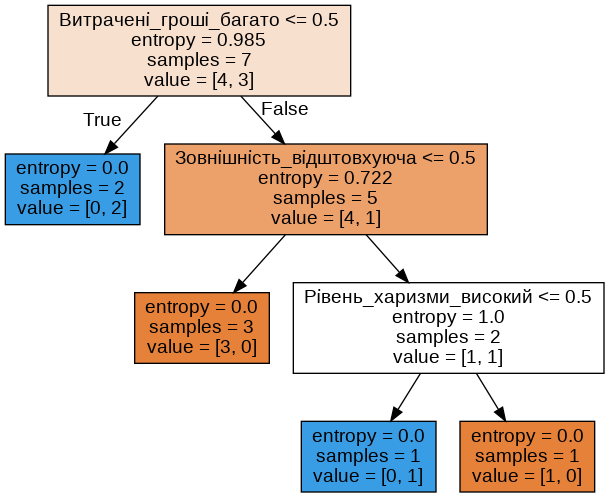

In [10]:
#Додатково: відобразіть дерево за допомогою graphviz. Можна використати бібліотеку pydotplus.
from graphviz import Source
from sklearn import tree



graph = Source( tree.export_graphviz(first_tree, out_file=None,feature_names =df_train.columns,filled=True))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

In [11]:
# Функції для обрахування ентропії й приросту інформації
balls = [1 for i in range(9)] + [0 for i in range(11)]

In [12]:
# дві групи
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синіх і 5 жовтих
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синя і 6 жовтих

In [13]:
#Реалізуйте функцію для обрахування ентропії Шеннона:
from math import log 
def entropy(a_list):
    
    temp = np.zeros(len(set(a_list)))
    s = 0
    index = 0
    
    for i in set(a_list):
        for j in a_list:
            if (i == j):
                temp[index] += 1
        index +=1
    
    for i in temp:
        s+= -i/len(a_list) * log(i/len(a_list))/log(2) 
    
    return s

In [14]:
#Перевіряємо працездатність функції entropy:
print(entropy(balls)) # 9 синіх і 11 жовтих
print(entropy(balls_left)) # 8 синіх і 5 жовтих
print(entropy(balls_right)) # 1 синя і 6 жовтих
print(entropy([1,2,3,4,5,6])) # ентропія гральної кості з незміщенним центром тяжіння

0.9927744539878083
0.961236604722876
0.5916727785823274
2.584962500721156


In [16]:
def information_gain(root, left, right):
    ''' root - початковий набір даних, left і right два розбиття початкового набору'''
    return entropy(root) - len(left)/len(root)* entropy(left) - len(right)/len(root)* entropy(right) 

In [18]:
#Завдання 2
print(entropy(balls_left))

0.961236604722876


In [19]:
#Завдання 3
print(information_gain(balls,balls_left ,balls_right))

0.16088518841412427


In [80]:
data_train_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-03_classification/adult_train.csv'
data_train = pd.read_csv(data_train_url, sep=';')

data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [81]:
data_test_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-03_classification/adult_test.csv'
data_test = pd.read_csv(data_test_url, sep=';')

data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [82]:
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

# перекодируем target в числовое поле
data_train.at[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.at[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.at[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.at[data_test['Target'] == ' >50K.', 'Target'] = 1

In [83]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

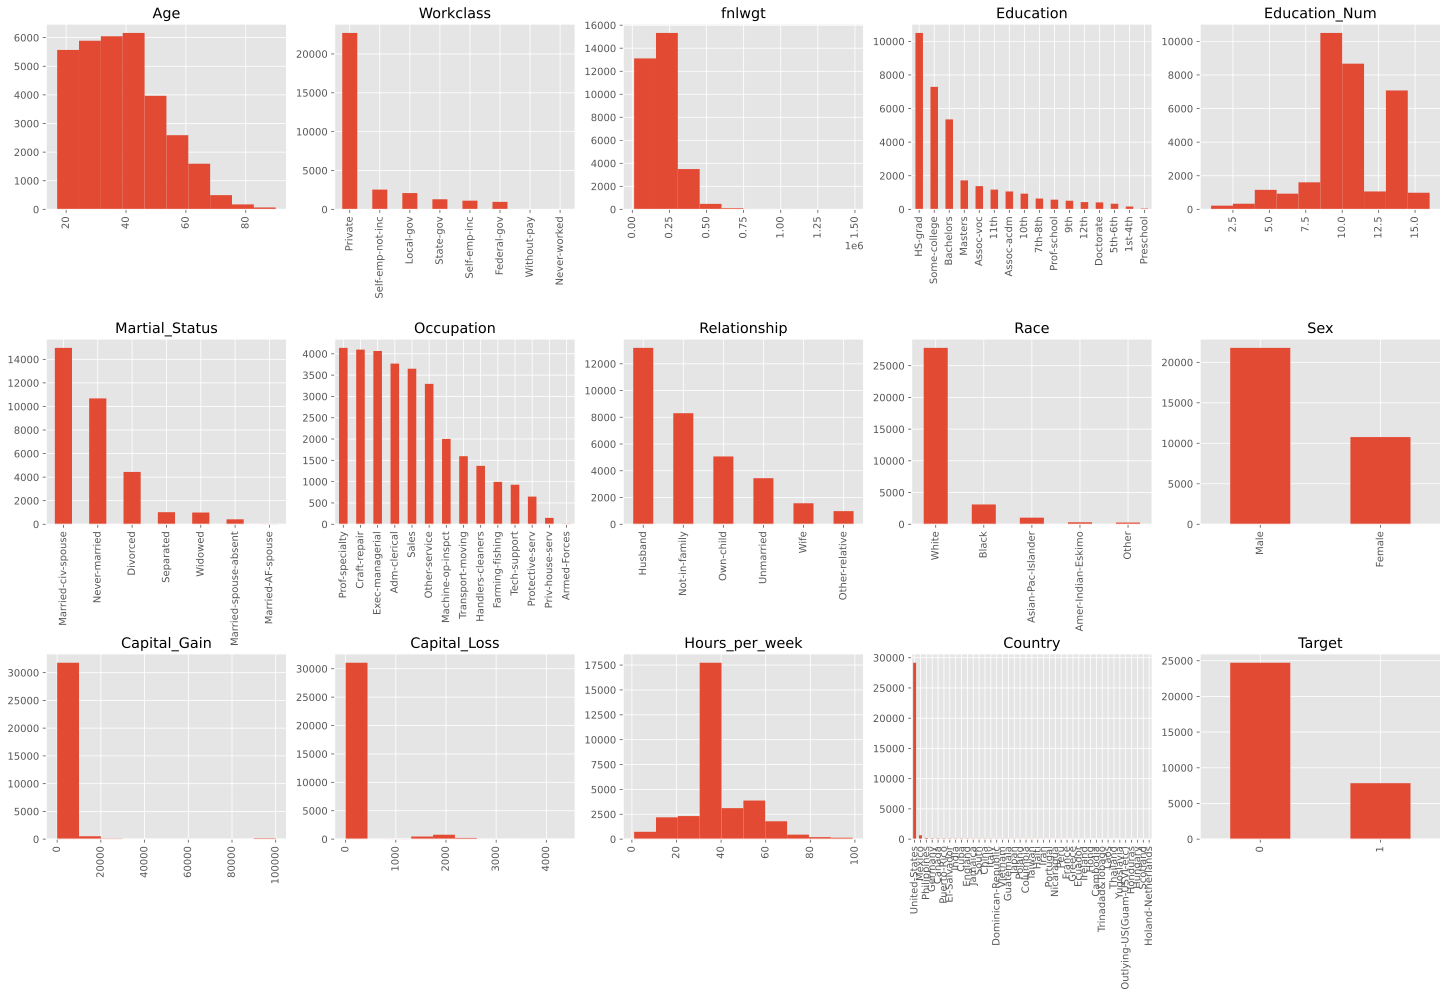

In [85]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [86]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [87]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

In [88]:
data_test['Age'] = data_test['Age'].astype(int)

In [89]:
data_test['Target'] = data_test['Target'].astype(int)

In [90]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

In [91]:
categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [92]:
for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())  

In [93]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [94]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [95]:
data_test.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...
Country_ Thailand,16281.0,0.000737,0.027140,0.0,0.0,0.0,0.0,1.0
Country_ Trinadad&Tobago,16281.0,0.000491,0.022162,0.0,0.0,0.0,0.0,1.0
Country_ United-States,16281.0,0.900559,0.299262,0.0,1.0,1.0,1.0,1.0
Country_ Vietnam,16281.0,0.001167,0.034143,0.0,0.0,0.0,0.0,1.0


In [96]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [97]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

In [98]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])


In [99]:
set(data_train.columns) - set(data_test.columns)

set()

In [100]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [101]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0


In [102]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

In [103]:
tree = DecisionTreeClassifier(max_depth=3, random_state = 17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [104]:
tree_predictions = tree.predict(X_test)

In [105]:
accuracy_score(y_test,tree_predictions)

0.8447884036607088

In [107]:
#Завдання 4
tree = DecisionTreeClassifier(max_depth=5, random_state = 19)
tree.fit(X_train, y_train)
tree_predictions = tree.predict(X_test)
accuracy_score(y_test,tree_predictions)

0.8520361157177078

In [108]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17),
                                 tree_params, cv=5)                     

locally_best_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': range(2, 11)})

In [109]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8562698879315647


In [110]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state = 17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test,tuned_tree_predictions)

0.8471838339168356

In [113]:
#Завдання 5
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=19),
                                 tree_params, cv=5)                     

locally_best_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=19),
             param_grid={'max_depth': range(2, 11)})

In [114]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8563313082774162


In [116]:
tuned_tree = DecisionTreeClassifier(max_depth=5, random_state = 19)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test,tuned_tree_predictions)

0.8520361157177078